# Part II: Human TVB-AdEx model simulating neuronal activity during different brain states 

## EITN Fall School, 19-28 November 2025, Marseille

## TVB-AdEx hands on session, 24 November 2025

###### *This code has been prepared by Lionel Kusch, Núria Tort-Colet, and Jennifer Goldman, Maria Sacha*
###### *Put in a tutorial form by Emre Baspinar*
###### *Coordinated by Alain Destexhe*

Contact: emre.baspinar@inria.fr

## Context

In Part I, we saw the AdEx mean-field model simulating asynchronous irregular (AI) and up-down states. The mean-field model approximates the averaged dynamics of the neuronal populations of a brain region. In Part II, we will extend this setting to multiple brain regions, i.e., to the whole brain, so as to simulate AI and up-down states on the whole-brain scale. To achieve it, we use The Virtual Brain in which the AdEx mean-field was embedded. For each region of the brain, we have a separate AdEx mean-field system to model the corresponding averaged neuronal dynamics to that region of the brain. These AdEx mean-field systems are coupled to each other via the connections provided by the human connectome obtained by following the human tractography methods from the Berlin empirical data processing pipeline [3]. It is based on diffusion-weighted imaging combined with mapping of macaque tracer studies on the human brain. The connectome includes 68 regions. The connectome data has been available at https://zenodo.org/records/7011292 since 17 January 2023. We refer to [1, 2] for the details of TVB-AdEx framework. 

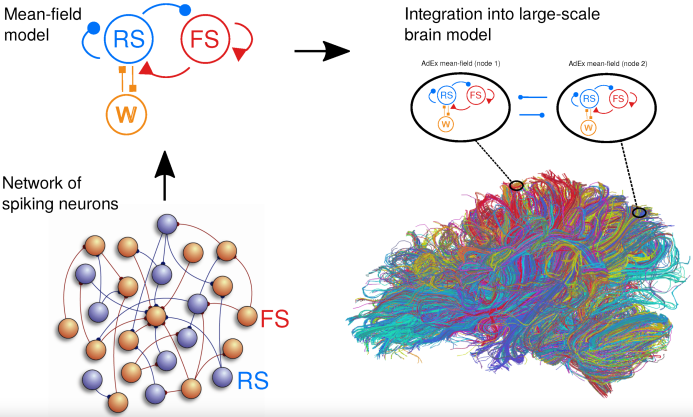

<b>Fig. 1: Figure adapted from [1, 2]: From AdEx network towards TVB model with nodes based on AdEx mean-field systems. Each node is modeled in terms of excitatory (regularly spiking, RS) and inhibitory (fast spiking, FS) neuronal populations, where RS population dynamics are modulated by spike-frequency adaptation. </b>

## Objective

The objective of this tutorial is to build a simulation setup based on TVB and AdEx mean-field model to generate neuronal dynamics regarding the AI and up-downs states at the whole-brain scale. More precisely,
- generate the AI state
- simulate the transition from the AI towards the up-down state
- generate the up-down state

## Initialization

Let us start with installing some dependencies and importing the modules which we will need for the simulations.

In [1]:
%%capture --no-display
# !pip install moviepy
# !pip install --upgrade tvb-library
# !pip install --upgrade tvb-data

In [2]:
## Some lines to get centered plots

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
%matplotlib inline

In [3]:
## Import TVB files:

from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
parameters = Parameter()
import tvb_model_reference.src.nuu_tools_simulation_human as tools
from tvb_model_reference.view.plot_human import multiview, multiview_one, prepare_surface_regions_human, animation_nuu

## Import tools:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from IPython.display import Video
from scipy import signal

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


## Plot and highlight the cortical regions

We can plot the results for all brain regions. However, sometimes, it is more practical to focus on specific regions. For this, we can use the numerical correspondence of the regions included in the human connectome and highlight the regions which we are interested in.

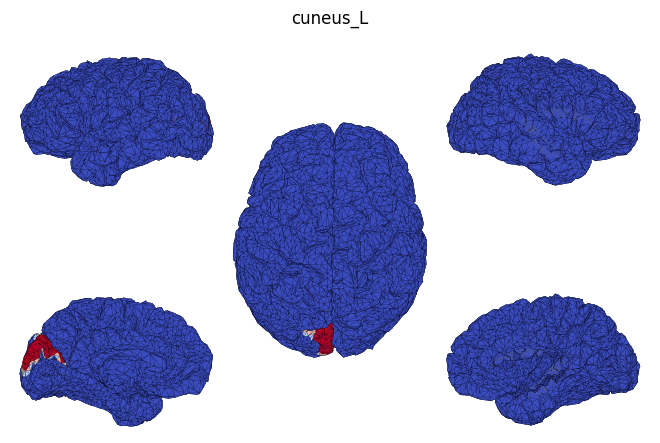

In [4]:
## Highlight one of the cortical regions of the model:

# needed for numpy>v1.24
np.float = float
np.int = int
# prepare surface plot:
cortex, conn, hemispheres_left, hemispheres_right =\
prepare_surface_regions_human(parameters, 
                              conn_filename='Connectivity.zip', 
                              zip_filename= 'Surface_Cortex.zip', 
                              region_map_filename = 'RegionMapping.txt')


# chose a region by its name or by region number: (find all names at conn.region_labels)
# id_region = 5
id_region = 6
region_name = conn.region_labels[id_region]


# plot the region
the_data = np.zeros((cortex.region_mapping_data.array_data.shape[0],))
multiview_one(cortex, hemispheres_left, hemispheres_right, 
              [id_region], the_data, plt.figure(), suptitle='', 
              title=region_name, figsize=(8, 8), shaded=False)


In [5]:
print (conn.region_labels[:])

['bankssts_L' 'bankssts_R' 'caudalanteriorcingulate_L'
 'caudalanteriorcingulate_R' 'caudalmiddlefrontal_L'
 'caudalmiddlefrontal_R' 'cuneus_L' 'cuneus_R' 'entorhinal_L'
 'entorhinal_R' 'frontalpole_L' 'frontalpole_R' 'fusiform_L' 'fusiform_R'
 'inferiorparietal_L' 'inferiorparietal_R' 'inferiortemporal_L'
 'inferiortemporal_R' 'insula_L' 'insula_R' 'isthmuscingulate_L'
 'isthmuscingulate_R' 'lateraloccipital_L' 'lateraloccipital_R'
 'lateralorbitofrontal_L' 'lateralorbitofrontal_R' 'lingual_L' 'lingual_R'
 'medialorbitofrontal_L' 'medialorbitofrontal_R' 'middletemporal_L'
 'middletemporal_R' 'paracentral_L' 'paracentral_R' 'parahippocampal_L'
 'parahippocampal_R' 'parsopercularis_L' 'parsopercularis_R'
 'parsorbitalis_L' 'parsorbitalis_R' 'parstriangularis_L'
 'parstriangularis_R' 'pericalcarine_L' 'pericalcarine_R' 'postcentral_L'
 'postcentral_R' 'posteriorcingulate_L' 'posteriorcingulate_R'
 'precentral_L' 'precentral_R' 'precuneus_L' 'precuneus_R'
 'rostralanteriorcingulate_L' 'ro

## Set up the simulation parameters

In [6]:
## Set the parameters of the simulation:

run_sim = 5000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

bvals = np.arange(0,60,20) # List of values of adaptation strength which will vary the brain state
simname = ['asynchronous','synchronous']
Iext = 0.000315 # Base drive


## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)

stimval = 0 #  stimulus strength -- no stimulation
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start
stim_region = 5 # .
# stim_region =   # .

Here we specify a location to save the simulation results.

In [7]:
## Define a location to save the files; create the folder if necessary:

folder_root = './result/brain_states/conn_latest_vers/'

try:
    os.listdir(folder_root)
except:
    os.makedirs(folder_root)
    

## Set up and run the simulation

We set up the simulator with the parameters chosen above and the human connectome.

In [8]:
## Set up the simulator:

simulator = tools.init(parameters.parameter_simulation,
                          parameters.parameter_model,
                          parameters.parameter_connection_between_region,
                          parameters.parameter_coupling,
                          parameters.parameter_integrator,
                          parameters.parameter_monitor)
#### Set up the simulator

We are ready to run the simulations. We run the simulations for several "b" values. As we increase "b", we increase the spike-frequency adaptation. This pushes the model from AI towards up-down state.

In [9]:
## Don't run this cell if you already have the simulation files stored
## Uncomment this cell to run a new simulation (i.e., if you change the parameters)
    
for simnum in range(len(bvals)):
    parameters.parameter_model['b_e'] = int(bvals[simnum])

    parameters.parameter_model['external_input_ex_ex']=Iext
    parameters.parameter_model['external_input_in_ex']=Iext

    weight = list(np.zeros(simulator.number_of_nodes))
    weight[stim_region] = stimval # region and stimulation strength of the region 0 

    parameters.parameter_stimulus["tau"]= stimdur # stimulus duration [ms]
    parameters.parameter_stimulus["T"]= 1e9 # interstimulus interval [ms]
    parameters.parameter_stimulus["weights"]= weight
    parameters.parameter_stimulus["variables"]=[0] #variable to kick


    print('b_e =',bvals[simnum])


    parameters.parameter_stimulus['onset'] = cut_transient + 0.5*(run_sim-cut_transient)
    stim_time = parameters.parameter_stimulus['onset']
    stim_steps = stim_time*10 #number of steps until stimulus

    parameters.parameter_simulation['path_result'] = folder_root +f'_b_{bvals[simnum]}'+'/'
    simulator = tools.init(parameters.parameter_simulation,
                          parameters.parameter_model,
                          parameters.parameter_connection_between_region,
                          parameters.parameter_coupling,
                          parameters.parameter_integrator,
                          parameters.parameter_monitor,
                          parameter_stimulation=parameters.parameter_stimulus)

    if stimval:
        print ('    Stimulating for {1} ms, {2} nS in the {0}\n'.format(simulator.connectivity.region_labels[stim_region],parameters.parameter_stimulus['tau'],stimval))

    tools.run_simulation(simulator,
                run_sim,                            
                parameters.parameter_simulation,
                parameters.parameter_monitor)
                  

b_e = 0
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
b_e = 20
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
b_e = 40
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0


## Plot the simulation time series

We choose for which "b" values we would like to plot the simulation time series and load the simulation results for these "b" values.

In [10]:
bvals = [0, 20, 40]

In [11]:
## Load simulation variables:

FR_exc = []
FR_inh = []
Ad_exc = []

for simnum in range(len(bvals)):

    '''load result'''
    sim_name = '_b_'+str(bvals[simnum])+'/'
    print ('... loading file: ' + sim_name)       
    file_name =  folder_root + sim_name
    result = tools.get_result(file_name,cut_transient,run_sim)
            
    '''fill variables'''
    time_s = result[0][0]*1e-3 #from ms to sec
    FR_exc.append(result[0][1][:,0,:]*1e3) # from KHz to Hz; Excitatory firing rate
    FR_inh.append(result[0][1][:,1,:]*1e3) # from KHz to Hz; Inhibitory firing rate
    Ad_exc.append(result[0][1][:,5,:]) # nA; Excitatory adaptation

    del result

... loading file: _b_0/
... loading file: _b_20/
... loading file: _b_40/


We plot the results for each "b" values. We plot both the excitatory and inhibitory population activity, as well as the time series of the spike-frequency adaptation variable.

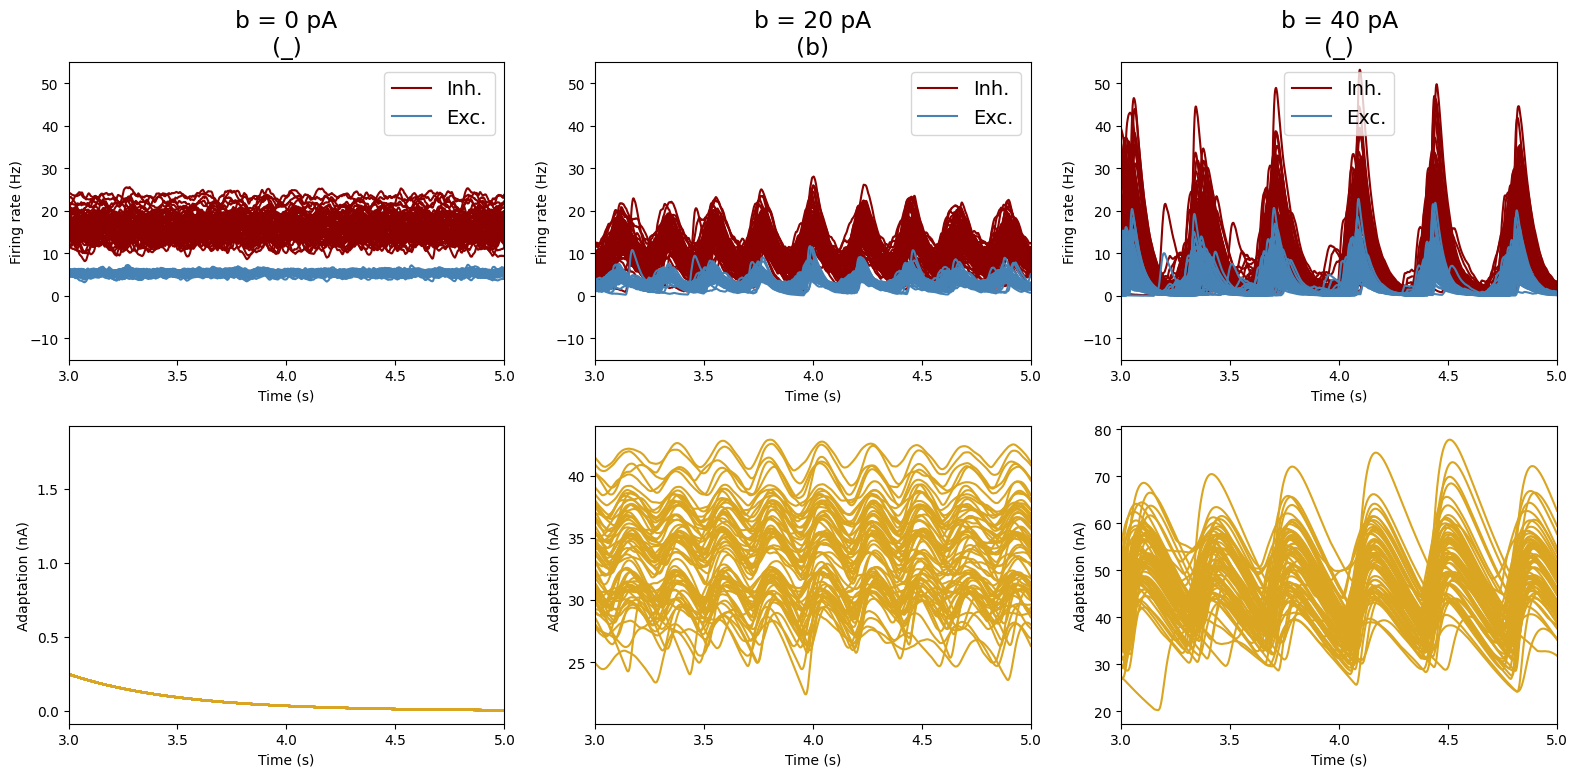

In [12]:
## Load simulation variables:

fig, axes = plt.subplots(2,3,figsize=(16,8))
plt.rcParams.update({'font.size': 14})

for simnum in range(len(bvals)):

    '''plot traces'''
    Li = axes[0,simnum].plot(time_s,FR_inh[simnum],color='darkred') # [times, regions]
    Le = axes[0,simnum].plot(time_s,FR_exc[simnum],color='SteelBlue') # [times, regions]

    axes[1,simnum].plot(time_s,Ad_exc[simnum],color='goldenrod') # [times, regions]

    axes[0,simnum].set_xlabel('Time (s)')
    axes[1,simnum].set_xlabel('Time (s)')

    axes[0,simnum].set_ylabel('Firing rate (Hz)')
    axes[1,simnum].set_ylabel('Adaptation (nA)')
    
    axes[0,simnum].set_title('b = {0} pA\n({1})'.format(bvals[simnum],sim_name[simnum]))
    axes[0,simnum].set_ylim([-15,55])
    axes[0,simnum].legend([Li[0], Le[0]], ['Inh.','Exc.'], loc='best')
    
    for ax in axes.reshape(-1):
        ax.set_xlim([3,5])
        ax.set_xticks([3,3.5,4,4.5,5])

plt.tight_layout()
plt.show()

## Functional connectivity matrices

For a rather quantitative identification of the brain states, we can have a look at the functional connectivity matrices.

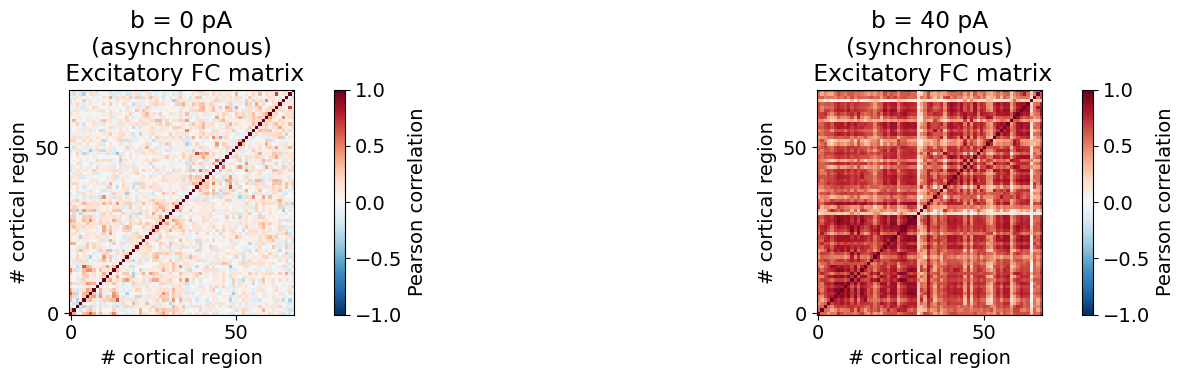

In [13]:
bvals = [0, 40]

fig, axes = plt.subplots(1, 2, figsize=(16,4))
plt.rcParams.update({'font.size': 14})

pearson_e = []
for simnum in range(len(bvals)):
    pearson_e.append(np.corrcoef(np.transpose(FR_exc[simnum])))
    im1 = axes[simnum].imshow(pearson_e[simnum], cmap = 'RdBu_r', vmin = -1, vmax = 1, 
           interpolation = 'nearest', origin='lower')
    fig.colorbar(im1, ax=axes[simnum],label='Pearson correlation')    
    axes[simnum].set_title('b = {0} pA\n({1})\n Excitatory FC matrix'.format(bvals[simnum],simname[simnum]))
    
for ax in axes.reshape(-1):
    ax.set_xlabel('# cortical region')
    ax.set_ylabel('# cortical region')
    ax.set_xticks([0,50])
    ax.set_yticks([0,50])

plt.tight_layout()
plt.show()

Here below, we provide the structural connectome used in our TVB-AdEx framework as well...

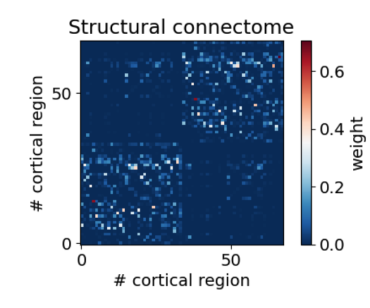

<b>Fig. 2: Structural connectome obtained via diffusion-weighted MRI.</b>

## References

[1]: Goldman, J. S., Kusch, L., Aquilue, D., Yalçınkaya, B. H., Depannemaecker, D., Ancourt, K., Nghiem, T. E., Jirsa, V., Destexhe, A. (2023). A comprehensive neural simulation of slow-wave sleep and highly responsive wakefulness dynamics. Frontiers in Computational Neuroscience, 16, 1058957.

[2]: Sacha, M., Goldman, J. S., Kusch, L., Destexhe, A. (2024). Asynchronous and slow-wave oscillatory states in connectome-based models of mouse, monkey and human cerebral cortex. Applied Sciences, 14(3), 1063.

[3]: Schirner, M.; Rothmeier, S.; Jirsa, V.K.; McIntosh, A.R.; Ritter, P. An automated pipeline for constructing personalized virtual brains from multimodal neuroimaging data. NeuroImage 2015, 117, 343–357.